### Importando librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

### Estructura de datos - Dataset Seoul Bike

*  Date - Día donde se rentaron bicicletas 
*  Rented Bike count - Cantidad de bicicletas arrendadas en cada hora
*  Hour - Hora del día (en formato 0 a 24)
*  Temperature - Temperatura en Celsius
*  Humidity - Porcentaje de humedad
*  Windspeed - Velocidad del viento en m/s
*  Visibility - Visibilidad atmosférica dentro de un rango de 10m
*  Dew point temperature - Temperatura del punto de rocío en Celsius
*  Solar radiation - Radiación Solar MJ/m2
*  Rainfall - mm de lluvia
*  Snowfall - cm de nieve caída 
*  Seasons - Temporada del año en inglés (Verano, Invierno, Otoño, Primavera)
*  Holiday - Flag representando de si es un Festivo o no
*  Functional Day - Flag mostrando si es un día funcional o no

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/patoram123/Proyecto_Visualizacion/main/datasets/public_bikes_2018/seul/SeoulBikeData.csv'
                ,encoding='unicode escape')

df['Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Revisando cantidad de valores nulos, unicos, duplicados y tipos de datos

In [3]:
def datainfo(data):
    print(f"Cantidad de columnas duplicadas: {len(data[data.duplicated()])}")
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    return temp_ps

In [4]:
datainfo(df)

Cantidad de columnas duplicadas: 0


,DataType,Non-null_Values,Unique_Values,NaN_Values
Date,datetime64[ns],8760,365,0
Rented Bike Count,int64,8760,2166,0
Hour,int64,8760,24,0
Temperature(°C),float64,8760,546,0
Humidity(%),int64,8760,90,0
Wind speed (m/s),float64,8760,65,0
Visibility (10m),int64,8760,1789,0
Dew point temperature(°C),float64,8760,556,0
Solar Radiation (MJ/m2),float64,8760,345,0
Rainfall(mm),float64,8760,61,0


* De aquí podemos notar como la mayoría de las variables son númericas y las variables categóricas están mapeadas como de tipo Object. No tenemos nulos y las variables categoricas cumplen lo esperado en la definición de datos.

### Correlación de Variables númericas

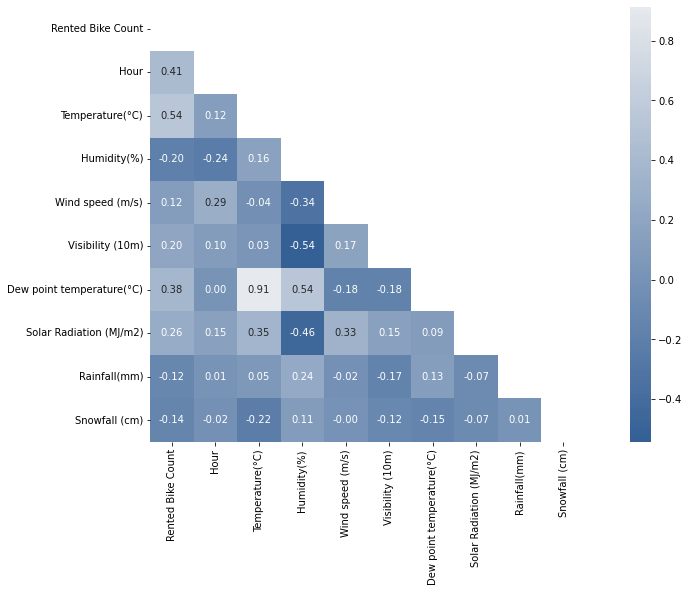

In [5]:
#matriz de correlacion 
corrMatrix = df.corr()
plt.rcParams['axes.facecolor'] = 'white'

mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                           n=9, center="light", as_cmap=True)

fig, ax = plt.subplots(figsize = (16, 8))

sns.heatmap(corrMatrix, mask=mask, center=1, annot=True,
            fmt='.2f', square=True, cmap=cmap)

sns.set(font_scale=0.8)

plt.show()

 Correlación entre Temperature(°C) y Dew point temperature(°C)


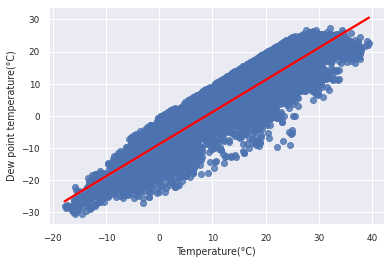

In [6]:
print("\033[1m Correlación entre Temperature(°C) y Dew point temperature(°C)")

sns.regplot(x = "Temperature(°C)", 
            y = "Dew point temperature(°C)"  , 
            data = df,
            line_kws={"color": "red"}) 
plt.show()

* Considerando la alta correlación que existe entre las variables `Dew point temperature(°C)` y `Temperature(°C)` se decide eliminar la primera

In [7]:
df.drop(['Dew point temperature(°C)'], axis = 1, inplace=True)
df.head(1)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Yes


### Creación y eliminación de columnas (cont.)

* La columna `Functioning Day`, que toma valores Yes o No, representa si ese día el servicio de arriendo de bicicletas estuvo operativo o no. Para los días no funcionales, la variable `Rented Bike Count` tiene solo valores 0 (cero), por lo que se decidió eliminar esas filas y por lo mismo, la columna `Functioning Day` que deja de tener valor.


* Para la variable fecha se aprovechará de obtener valor al separar en nuevas variables: Día y Mes. Elimando la columna `Date` del Dataset

In [8]:
print("******* Functioning Day *******")
print(df['Functioning Day'].value_counts())

print("\n\n******* Rented Bikes when Functioning Day is No *******")
print(df[df['Functioning Day']=="No"]['Rented Bike Count'].value_counts())

******* Functioning Day *******
Yes    8465
No      295
Name: Functioning Day, dtype: int64


******* Rented Bikes when Functioning Day is No *******
0    295
Name: Rented Bike Count, dtype: int64


In [9]:
# Quitando filas donde Functioning Day es No
df = df[df['Functioning Day']=="Yes"].reset_index(drop=True)
print(df['Functioning Day'].value_counts())

# Quitando la columna fecha ya que no aportará al modelo
df.drop(columns=['Functioning Day'],inplace=True)

Yes    8465
Name: Functioning Day, dtype: int64


In [10]:
# Creando variables de día y mes
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

# Quitando la columna fecha ya que no aportará al modelo
df.drop(columns=['Date'],inplace=True)

df.head(1)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,12,1


### Box plot de Variables categóricas vs Variable dependiente

* En los box plots se puede apreciar la diferencia de las medianas de la variable objetivo respecto a la estación y al tipo de día. En invierno la mediana del arriendo de bicicletas es casi cinco veces menor que en verano, y en días festivos la mediana es casi cuatro veces inferior que en un día normal.

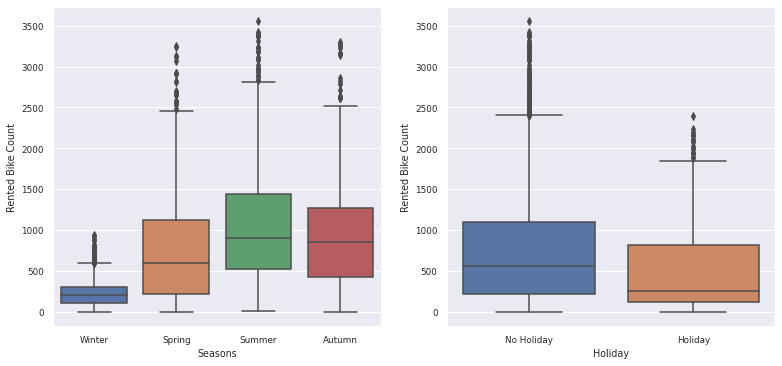

In [11]:
#Box plot de cada variable independiente v/s la variable dependiente
columns=['Seasons','Holiday']

fig=plt.figure(figsize=(20,20))
for i,cols in enumerate(columns): 
    ax=fig.add_subplot(3,3,i+1)
    sns.boxplot(x=cols,y='Rented Bike Count', data=df,ax=ax)

### Distribución de los datos

In [12]:
df.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Day,Month
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,0.567868,0.14912,0.077685,15.786651,6.493325
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,0.868245,1.12554,0.444063,8.821231,3.463349
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,0.000000,0.00000,0.000000,1.000000,1.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,0.000000,0.00000,0.000000,8.000000,4.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,0.010000,0.00000,0.000000,16.000000,6.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,0.930000,0.00000,0.000000,23.000000,10.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,3.520000,35.00000,8.800000,31.000000,12.000000


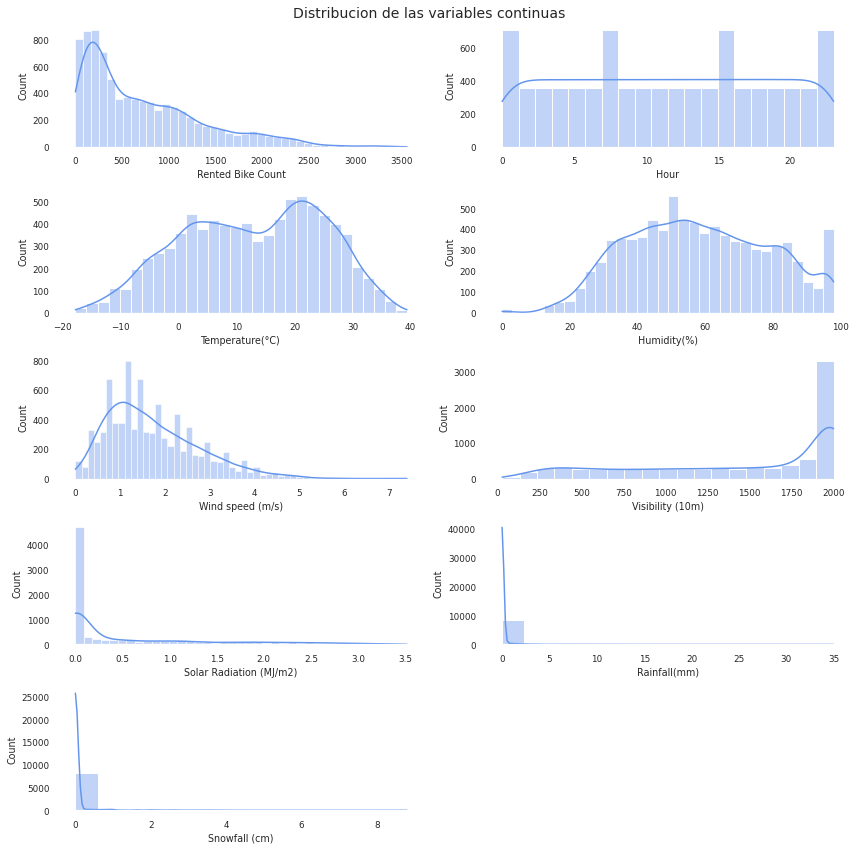

In [13]:
columnas = df.drop(['Day', 'Month', 'Seasons', 'Holiday'], axis=1).columns

count = 1

plt.figure(figsize=(12, 12))
for i in columnas:
    plt.rcParams['axes.facecolor'] = 'white'
    plt.subplot(5,2, count)
    sns.histplot(x=df[i], color='#6495ED',kde=True, alpha=0.4)
    count += 1
plt.suptitle('Distribucion de las variables continuas', fontsize=14)
plt.tight_layout()

### One Hot Encoding para Variables Categoricas

* Para obtener valores numericos de las variables categoricas, se decidió transformarlas usando "Dummyficación" o One Hot Encoding, lo cual implica crear tantas columnas como categorías existan y asignar un 1 donde la variable tome el valor que corresponda.

In [14]:
df = pd.get_dummies(df, columns=['Seasons', 'Holiday'], drop_first=True)
df.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Day,Month,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_No Holiday
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,12,1,0,0,1,1
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,12,1,0,0,1,1
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,12,1,0,0,1,1
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,12,1,0,0,1,1
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,12,1,0,0,1,1


### Exportando Dataset final

In [15]:
df.to_csv("Clean_SeoulBikeData.csv", index=False)